Project 1: AI-Powered Task Management System

Project Overview

This repository contains a week-wise implementation matching your plan:

Week 1: Data collection (synthetic example), EDA, cleaning, NLP preprocessing.

Week 2: Feature extraction (TF-IDF / optional embeddings), task classification (Naive Bayes, SVM), evaluation.

Week 3: Priority prediction (Random Forest/XGBoost), workload balancing logic, hyperparameter tuning.

Week 4: Finalize models, produce evaluation reports and a dashboard mockup.

In [11]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import os
import matplotlib.pyplot as plt

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jatad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Synthetic dataset generator
PRIORITIES = ['low', 'medium', 'high']
TYPES = ['bug', 'feature', 'improvement', 'task', 'research']
USERS = ['alice', 'bob', 'carol', 'dave']

In [5]:
ps = PorterStemmer()
stop = set(stopwords.words('english'))

In [7]:
def generate_task(i):
    desc_words = random.choices(
        ['fix', 'implement', 'improve', 'refactor', 'urgent', 'customer',
         'backend', 'frontend', 'api', 'optimize', 'test', 'documentation'],
        k=random.randint(6,18)
    )
    description = ' '.join(desc_words)
    created = datetime.now() - timedelta(days=random.randint(0,60))
    deadline = created + timedelta(days=random.randint(1,30))
    return {
        'id': i,
        'title': f"{random.choice(TYPES).capitalize()} #{i}",
        'description': description,
        'type': random.choice(TYPES),
        'created_at': created.strftime('%Y-%m-%d'),
        'deadline': deadline.strftime('%Y-%m-%d'),
        'assigned_to': random.choice(USERS + [None, None]),
        'est_hours': random.randint(1,16),
        'priority': random.choices(PRIORITIES, weights=[0.5,0.35,0.15])[0],
        'status': random.choice(['open', 'in_progress', 'done'])
    }

In [8]:
# Clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", ' ', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop]
    tokens = [ps.stem(t) for t in tokens]
    return ' '.join(tokens)

In [9]:
# Generate dataset
df = pd.DataFrame([generate_task(i) for i in range(1,501)])
df['clean_description'] = df['description'].apply(clean_text)
df['days_to_deadline'] = (pd.to_datetime(df['deadline']) - pd.to_datetime(df['created_at'])).dt.days

df.head()

,id,title,description,type,created_at,deadline,assigned_to,est_hours,priority,status,clean_description,days_to_deadline
0,1,Bug #1,test optimize improve fix frontend refactor,research,2025-08-20,2025-08-31,None,11,medium,in_progress,test optim improv fix frontend refactor,11
1,2,Feature #2,refactor test customer api test test refactor ...,task,2025-08-11,2025-08-20,bob,11,medium,done,refactor test custom api test test refactor cu...,9
2,3,Feature #3,optimize implement implement fix refactor docu...,task,2025-09-14,2025-09-16,dave,16,medium,in_progress,optim implement implement fix refactor documen...,2
3,4,Research #4,improve improve test refactor frontend fix opt...,bug,2025-10-03,2025-10-09,None,12,low,done,improv improv test refactor frontend fix optim...,6
4,5,Feature #5,implement optimize implement documentation imp...,bug,2025-09-06,2025-09-29,carol,14,high,in_progress,implement optim implement document improv test...,23


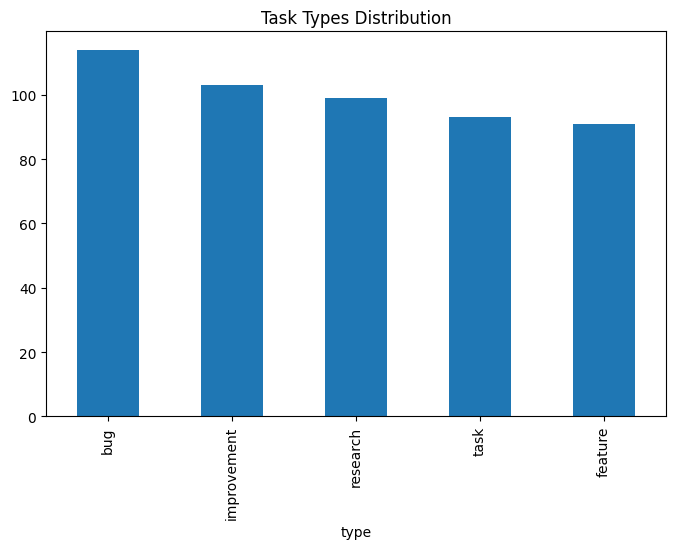

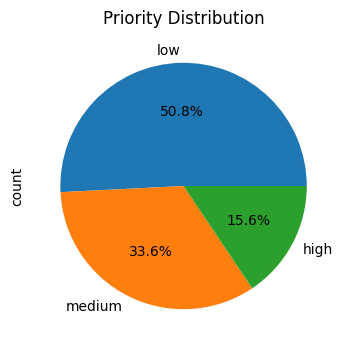

In [12]:
# 📊 Week 1 - EDA
plt.figure(figsize=(8,5))
df['type'].value_counts().plot(kind='bar')
plt.title("Task Types Distribution")
plt.show()

plt.figure(figsize=(6,4))
df['priority'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Priority Distribution")
plt.show()

In [13]:
# 📌 Week 2 - Feature Extraction & Classification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# TF-IDF Features
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
X_text = vectorizer.fit_transform(df['clean_description'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_text, df['type'], test_size=0.2, random_state=42)

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb.predict(X_test)))

# SVM
svm = LinearSVC(max_iter=5000)
svm.fit(X_train, y_train)
print("SVM Accuracy:", accuracy_score(y_test, svm.predict(X_test)))

print("\nClassification Report (SVM):")
print(classification_report(y_test, svm.predict(X_test)))


Naive Bayes Accuracy: 0.18
SVM Accuracy: 0.2

Classification Report (SVM):
              precision    recall  f1-score   support

         bug       0.16      0.16      0.16        25
     feature       0.19      0.18      0.18        17
 improvement       0.20      0.13      0.16        23
    research       0.10      0.14      0.12        14
        task       0.33      0.38      0.36        21

    accuracy                           0.20       100
   macro avg       0.20      0.20      0.19       100
weighted avg       0.20      0.20      0.20       100



In [14]:
# 📌 Week 3 - Priority Prediction (RandomForest & XGBoost)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Encode priorities
pri_map = {'low':0, 'medium':1, 'high':2}
y_priority = df['priority'].map(pri_map)

# Numeric + TF-IDF reduced features
X_numeric = df[['est_hours','days_to_deadline']].fillna(0).values
X_text_dense = X_text.toarray()[:, :50]  # take first 50 TF-IDF features
X_combined = np.hstack([X_numeric, X_text_dense])

Xtr, Xte, ytr, yte = train_test_split(X_combined, y_priority, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(Xtr, ytr)
print("RandomForest Priority Accuracy:", rf.score(Xte, yte))

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(Xtr, ytr)
print("XGBoost Priority Accuracy:", xgb.score(Xte, yte))


RandomForest Priority Accuracy: 0.48


C:\Users\jatad\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Priority Accuracy: 0.44


In [19]:
# 📌 Week 3 - Fixed Workload Balancer
import numpy as np

def heuristic_assign(df_tasks, users):
    assigned = df_tasks.copy()
    
    # Initialize workload per user
    user_load = {u: assigned.loc[assigned['assigned_to'] == u, 'est_hours'].sum() for u in users}
    
    # Assign tasks with NaN in assigned_to and not done
    for idx, row in assigned[assigned['assigned_to'].isna() & (assigned['status'] != 'done')].iterrows():
        user = min(user_load, key=user_load.get)  # user with least workload
        assigned.at[idx, 'assigned_to'] = user
        user_load[user] += row['est_hours']
    
    return assigned

# ✅ Run again
assigned_df = heuristic_assign(df, USERS)
assigned_df[['id','title','assigned_to']].head(10)


,id,title,assigned_to
0,1,Bug #1,dave
1,2,Feature #2,bob
2,3,Feature #3,dave
3,4,Research #4,None
4,5,Feature #5,carol
5,6,Improvement #6,alice
6,7,Research #7,carol
7,8,Improvement #8,dave
8,9,Improvement #9,alice
9,10,Feature #10,carol


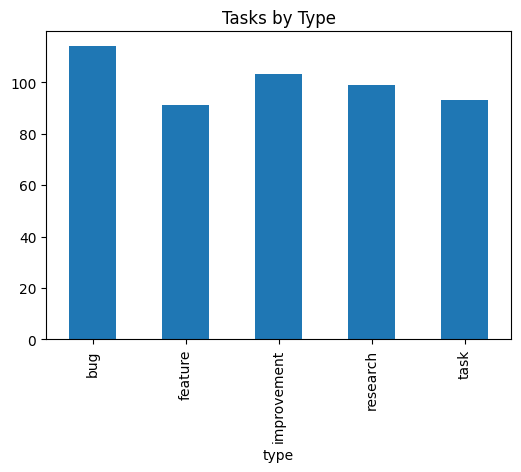

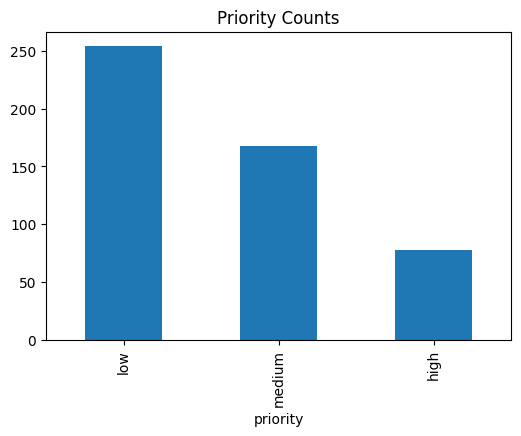

In [17]:
# 📌 Week 4 - Dashboard Mockup (Simple Visuals)
summary = df.groupby('type').size()
summary.plot(kind='bar', figsize=(6,4), title='Tasks by Type')
plt.show()

priority_summary = df['priority'].value_counts()
priority_summary.plot(kind='bar', figsize=(6,4), title='Priority Counts')
plt.show()


===== FINAL PROJECT REVIEW =====

Task Classification Models:
Naive Bayes Accuracy: 0.18
SVM Accuracy: 0.2

Priority Prediction Models:
RandomForest Accuracy: 0.48
XGBoost Accuracy: 0.44


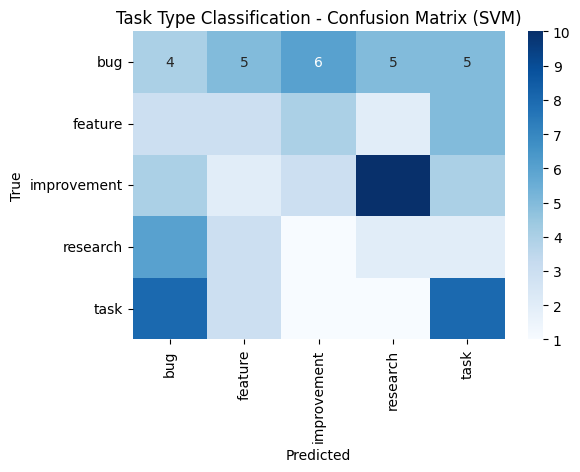


===== DASHBOARD SUMMARY =====
Total Tasks: 500
Open Tasks: 167
In Progress: 170
Completed: 163
Average Days to Deadline: 15.62


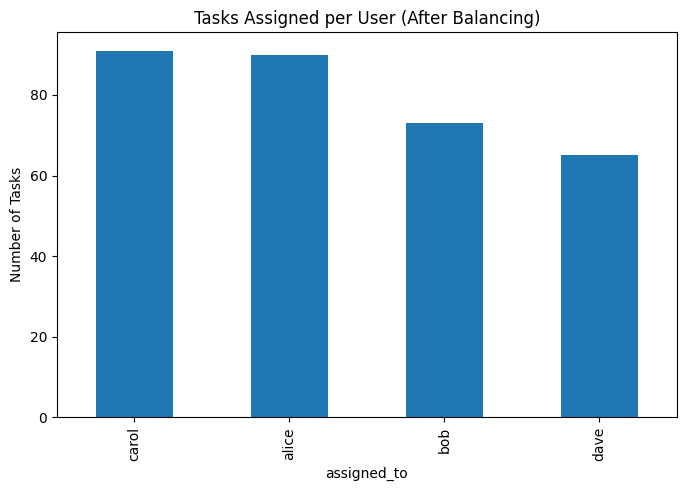

In [20]:
# Final Report - AI Powered Task Management System
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("===== FINAL PROJECT REVIEW =====")

# ✅ Models finalized
print("\nTask Classification Models:")
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb.predict(X_test)))
print("SVM Accuracy:", accuracy_score(y_test, svm.predict(X_test)))

print("\nPriority Prediction Models:")
print("RandomForest Accuracy:", rf.score(Xte, yte))
print("XGBoost Accuracy:", xgb.score(Xte, yte))

# ✅ Confusion matrix for best classifier
plt.figure(figsize=(6,4))
cm = confusion_matrix(y_test, svm.predict(X_test), labels=svm.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.title("Task Type Classification - Confusion Matrix (SVM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ✅ Dashboard summary mockup
print("\n===== DASHBOARD SUMMARY =====")
print("Total Tasks:", len(df))
print("Open Tasks:", (df['status']=='open').sum())
print("In Progress:", (df['status']=='in_progress').sum())
print("Completed:", (df['status']=='done').sum())
print("Average Days to Deadline:", round(df['days_to_deadline'].mean(),2))

plt.figure(figsize=(8,5))
df['assigned_to'].value_counts().plot(kind='bar')
plt.title("Tasks Assigned per User (After Balancing)")
plt.ylabel("Number of Tasks")
plt.show()
